In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sinkhorn_knopp import sinkhorn_knopp as skp
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA']
adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = shuffle_adata(adata)
adata

View of AnnData object with n_obs × n_vars = 1193 × 25404

In [2]:
#######data cleaning#######

sc.pp.filter_genes(adata, min_cells=1)
sc.pp.filter_cells(adata, min_counts=4000)
adata_for_inference = adata.copy()
adata

Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 738 × 25404
    obs: 'n_counts'
    var: 'n_cells'

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:205: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off


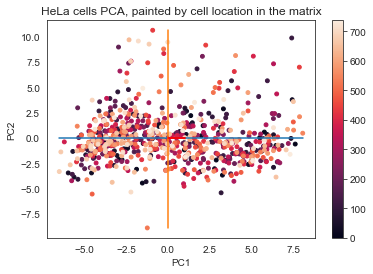

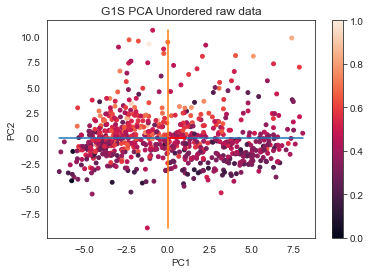

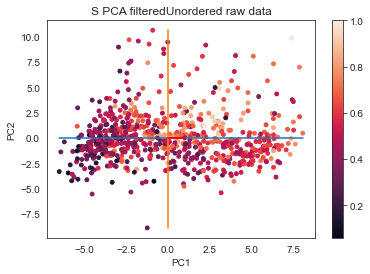

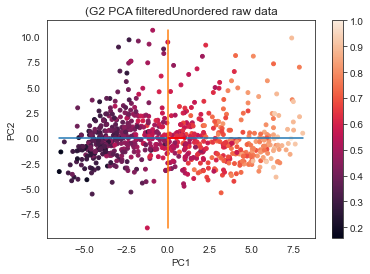

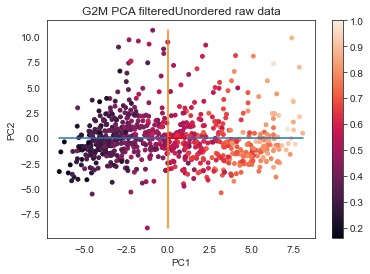

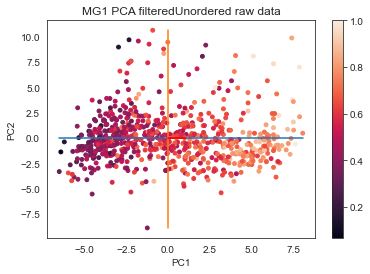

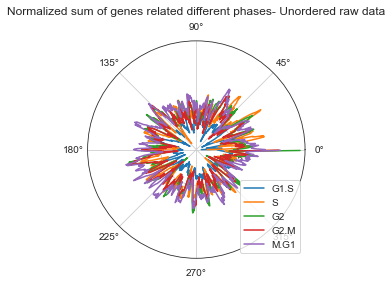

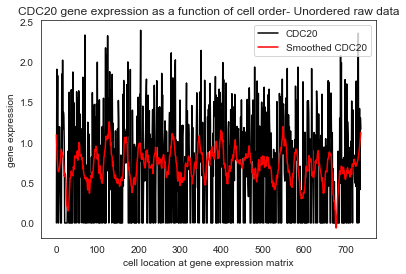

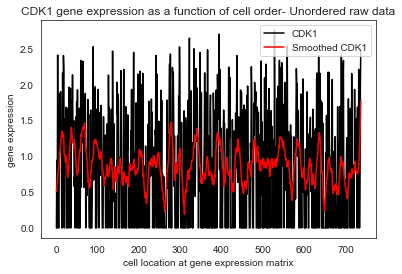

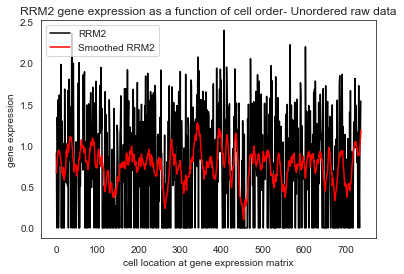

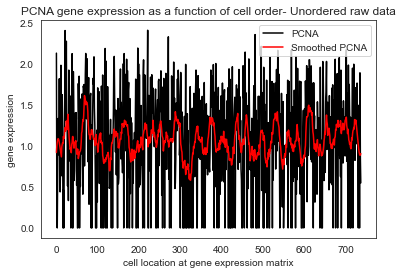

Mean AUC-ROC: 0.2861675


In [3]:
#######data cleaning#######
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
sc.pp.filter_genes_dispersion(adata,n_top_genes=4000)
all_plots_hela(adata,title="Unordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='r', title="Unordered raw data")
#######Gene inference over un-ordered data- the result expected to be low#######
auc_unordered= np.zeros(100)
for i in range(100):
    auc_unordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_unordered)))

Iteration number: 0 function value= 2.4642953221150733e-23
Iteration number: 25 function value= 716.6911166538322
Iteration number: 50 function value= 717.5859035815992
Iteration number: 75 function value= 726.9960515943174
Iteration number: 100 function value= 750.2362957416775
Iteration number: 125 function value= 753.1829892324747
Iteration number: 150 function value= 752.0413916312061
Iteration number: 175 function value= 756.8811157840556
Iteration number: 200 function value= 737.289670927591
Iteration number: 225 function value= 740.1019111565971


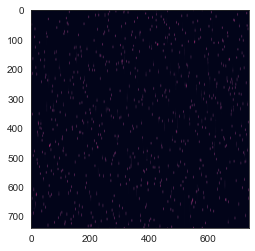

In [4]:
E_sga  , E_rec_sga = reconstruction_cyclic(adata.X , iterNum=250 , batch_size=2500)
plt.imshow(E_sga)
plt.show()

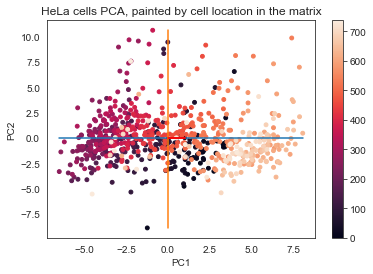

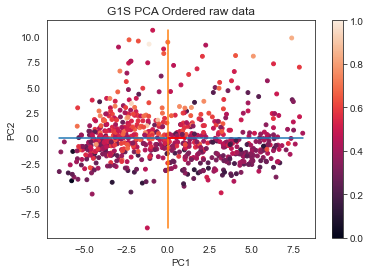

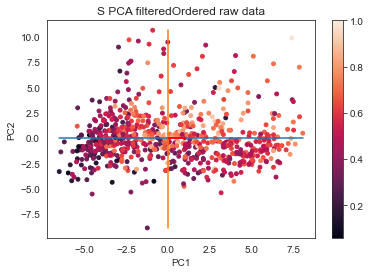

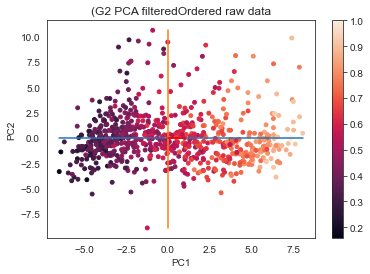

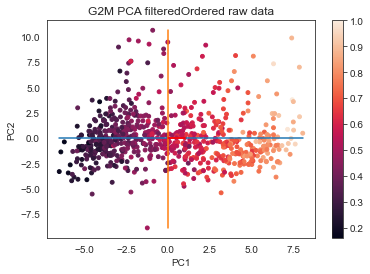

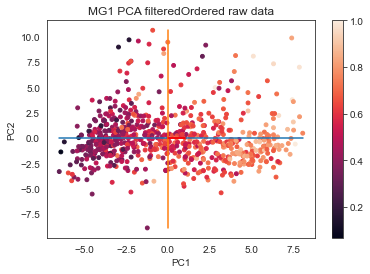

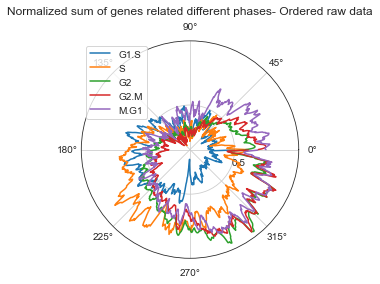

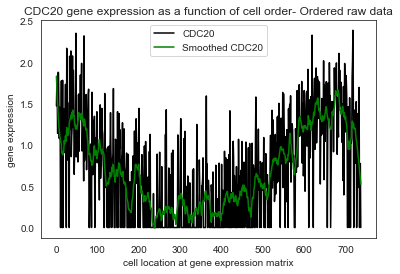

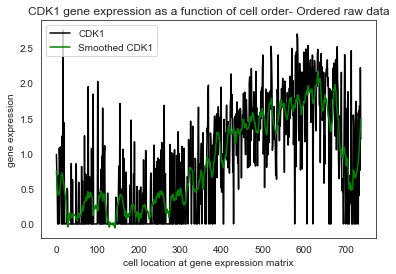

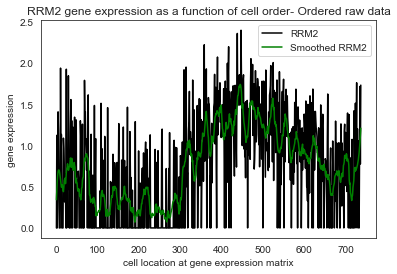

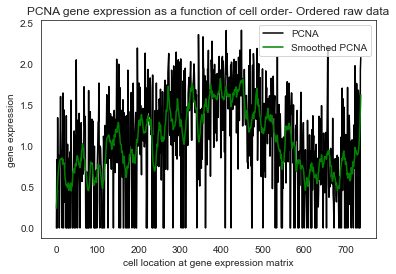

Mean AUC-ROC: 0.8265495


In [5]:
#######Signal reconstruction######
sga_range= e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())
all_plots_hela(adata,title="Ordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='g', title="Ordered raw data")
auc_ordered= np.zeros(100)
#######Gene inference over ordered data#######
for i in range(100):
    auc_ordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_ordered)))

Iteration number: 1 function value: 676.9633570612002
Iteration number: 26 function value: 2104.6874235822643
Iteration number: 51 function value: 4241.859849607253
Iteration number: 76 function value: 5322.759127754502
Iteration number: 101 function value: 5929.783756407418
Iteration number: 126 function value: 6253.93814276715
Iteration number: 151 function value: 6427.923431795817
Iteration number: 176 function value: 6531.599263642254


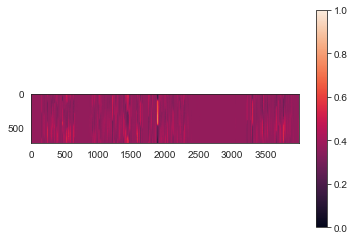

norm change 529.6908041806104


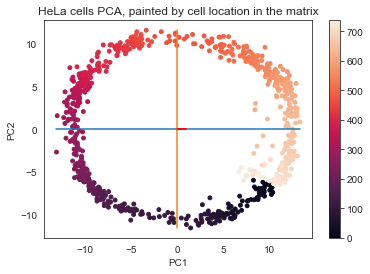

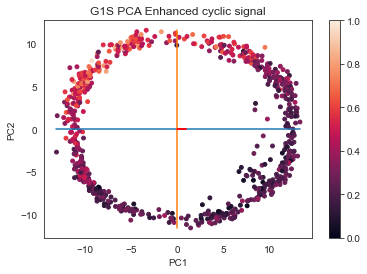

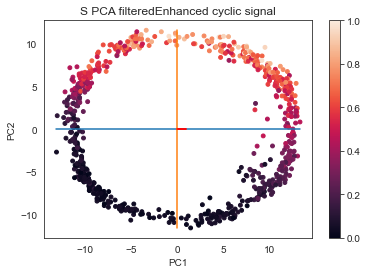

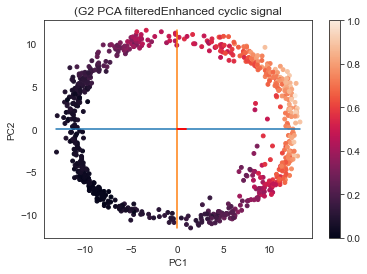

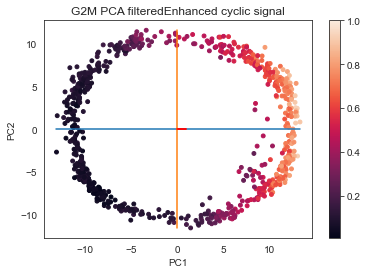

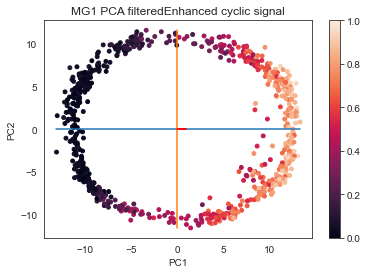

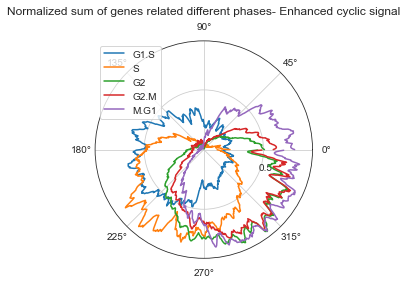

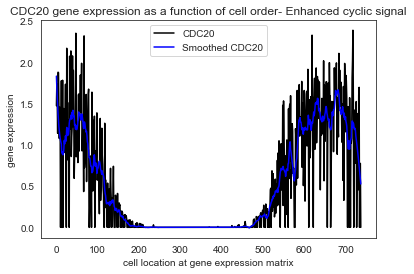

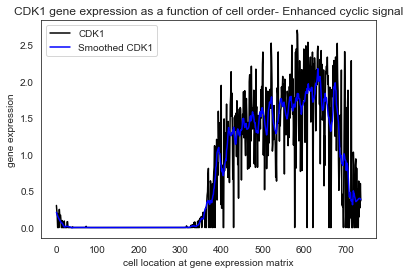

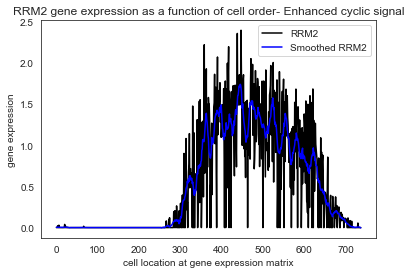

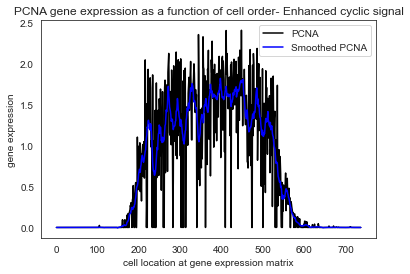

Mean AUC-ROC: 0.855011


In [6]:
#######Signal enhancement######
adata = orig_adata.copy()
F = enhancement_cyclic(adata.X,regu=0.05,iterNum=200)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Enhanced cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='b', title="Enhanced cyclic signal")
auc_en= np.zeros(100)
for i in range(100):
    auc_en[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_en)))

starting filtering
25th Iteration    Loss :: 83.32164770005704 gradient :: 2.5113826012552036
50th Iteration    Loss :: 37.61254617221198 gradient :: 1.49922393303806
75th Iteration    Loss :: 24.91399824113734 gradient :: 0.7892155561604773
100th Iteration    Loss :: 18.821601959120567 gradient :: 0.6067622253574776
125th Iteration    Loss :: 15.388884393721751 gradient :: 0.5624097143573065
150th Iteration    Loss :: 13.21212590959313 gradient :: 0.37903173182775723
175th Iteration    Loss :: 11.662349352056014 gradient :: 0.3223039664019224
200th Iteration    Loss :: 10.49584175610936 gradient :: 0.287690254719167
225th Iteration    Loss :: 9.597595278036362 gradient :: 0.2695142006262394
250th Iteration    Loss :: 8.882097387365581 gradient :: 0.27118514774856156
275th Iteration    Loss :: 8.297566074079356 gradient :: 0.22587358971050597
300th Iteration    Loss :: 7.806557659417004 gradient :: 0.19316468988549845
325th Iteration    Loss :: 7.385601973994021 gradient :: 0.176894903

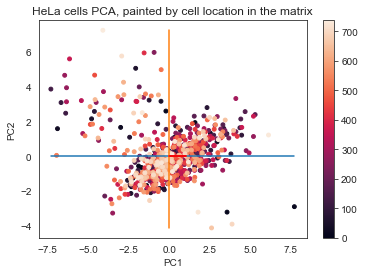

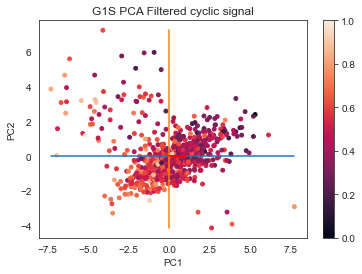

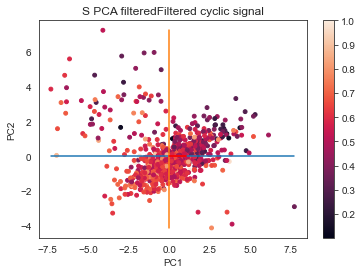

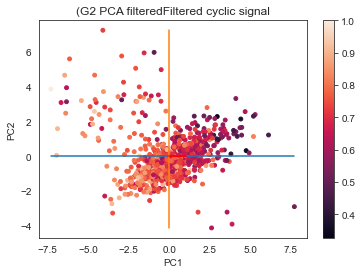

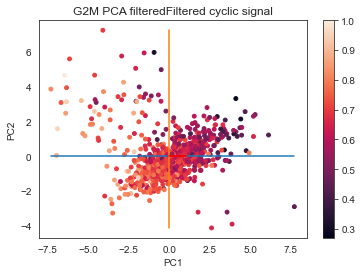

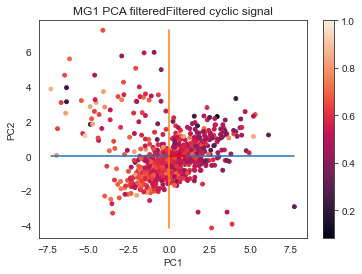

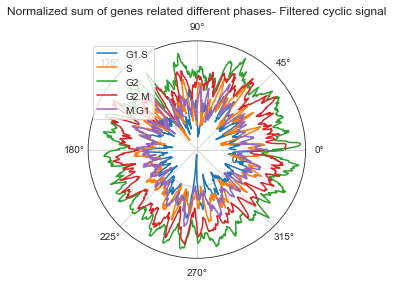

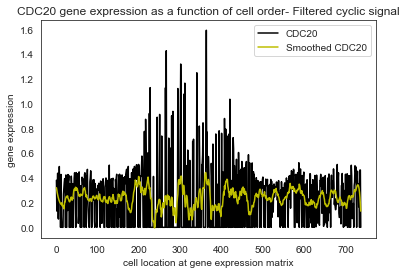

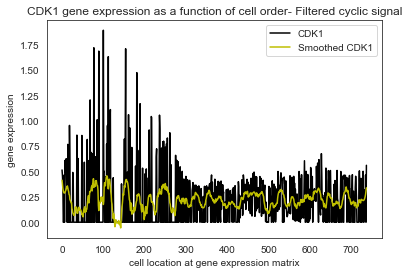

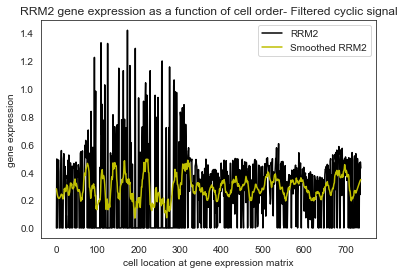

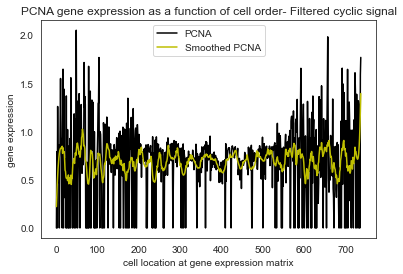

Mean AUC-ROC: 0.23918149999999996


In [7]:
#######Signal filtering######
adata = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata.X,regu=0,iterNum=1500)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Filtered cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='y', title="Filtered cyclic signal")
auc_filtered= np.zeros(100)
for i in range(100):
    auc_filtered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_filtered)))

starting norm: 819.9306
Iteration number: 1 function value: 676.9485360057064


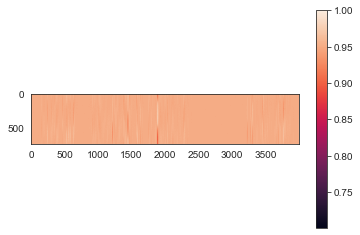

norm change 53.42117361714808


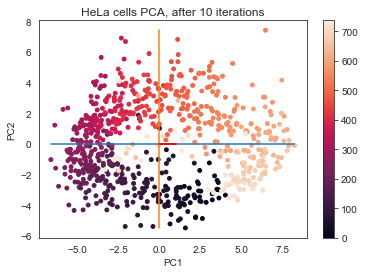

Iteration number: 1 function value: 1015.2960808744547


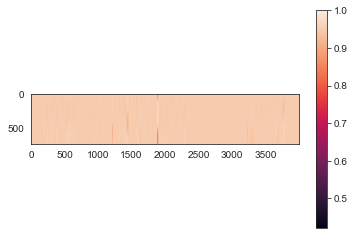

norm change 119.02960966904867


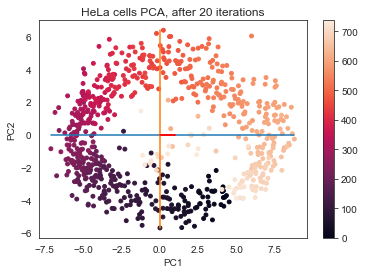

Iteration number: 1 function value: 1807.5887732417068


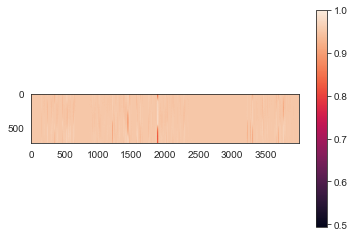

norm change 182.29558477960532


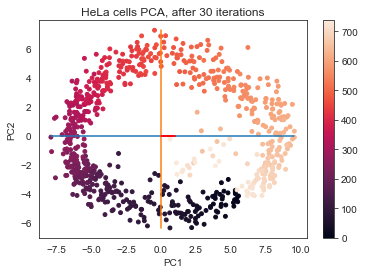

Iteration number: 1 function value: 3196.1587700465225


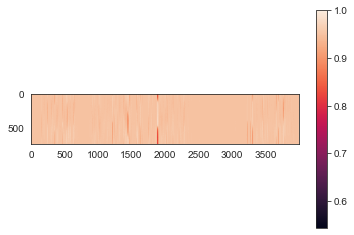

norm change 234.8704295312065


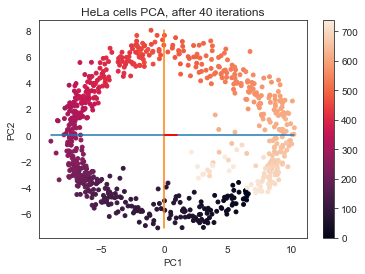

Iteration number: 1 function value: 5040.663280328979


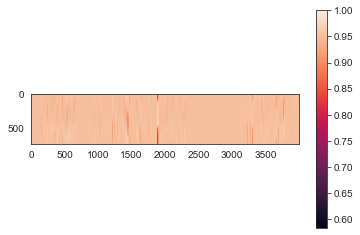

norm change 277.46606447384994


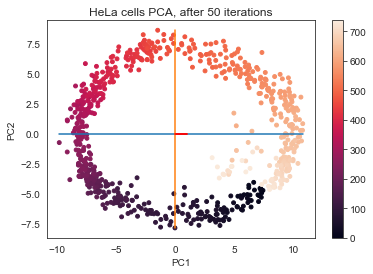

Iteration number: 1 function value: 7156.240901258878


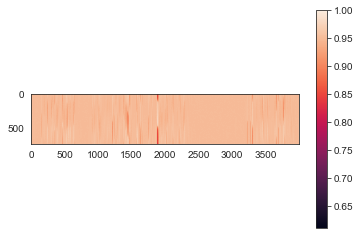

norm change 312.3288230619961


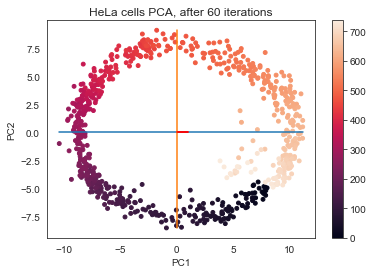

Iteration number: 1 function value: 9382.866779837479


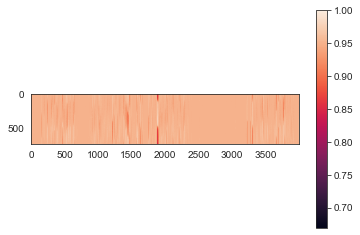

norm change 341.1737781473667


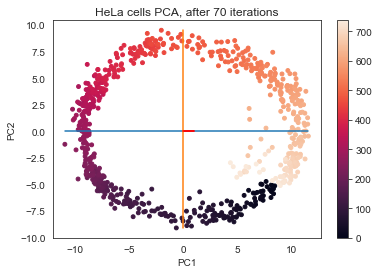

Iteration number: 1 function value: 11590.431580144033


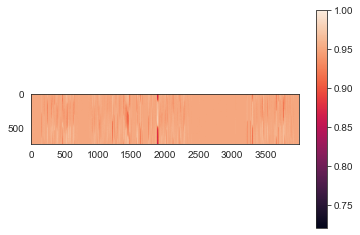

norm change 365.3136059939206


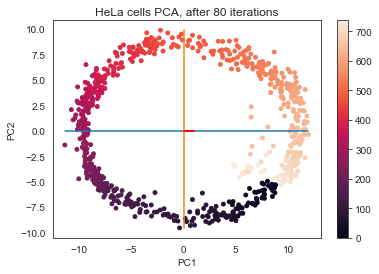

Iteration number: 1 function value: 13685.065495036057


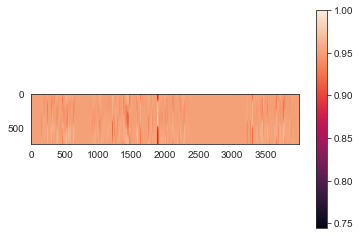

norm change 385.75688821996874


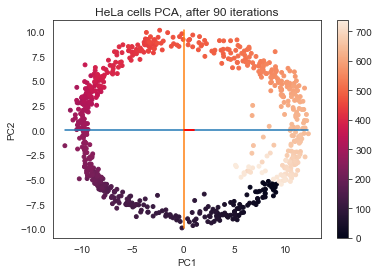

Iteration number: 1 function value: 15629.461309033517


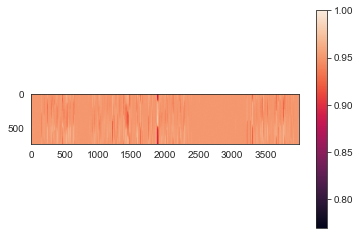

norm change 403.3008739526775


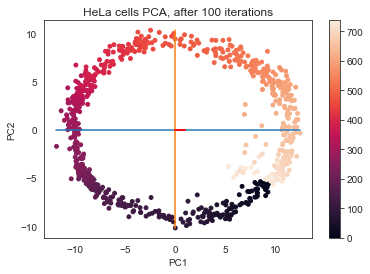

In [8]:
print("starting norm: " +str(np.linalg.norm(orig_adata.X)))
adata = copy.deepcopy(orig_adata.copy())
for i in range(10):
    F = filter_full(adata.X,regu=0.05,iterNum=10)
    print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
    adata.X = adata.X * F
    ranged_pca_2d(adata.X,color=range(adata.X.shape[0]),title=("HeLa cells PCA, after "+ str((i+1)*10) +" iterations"))

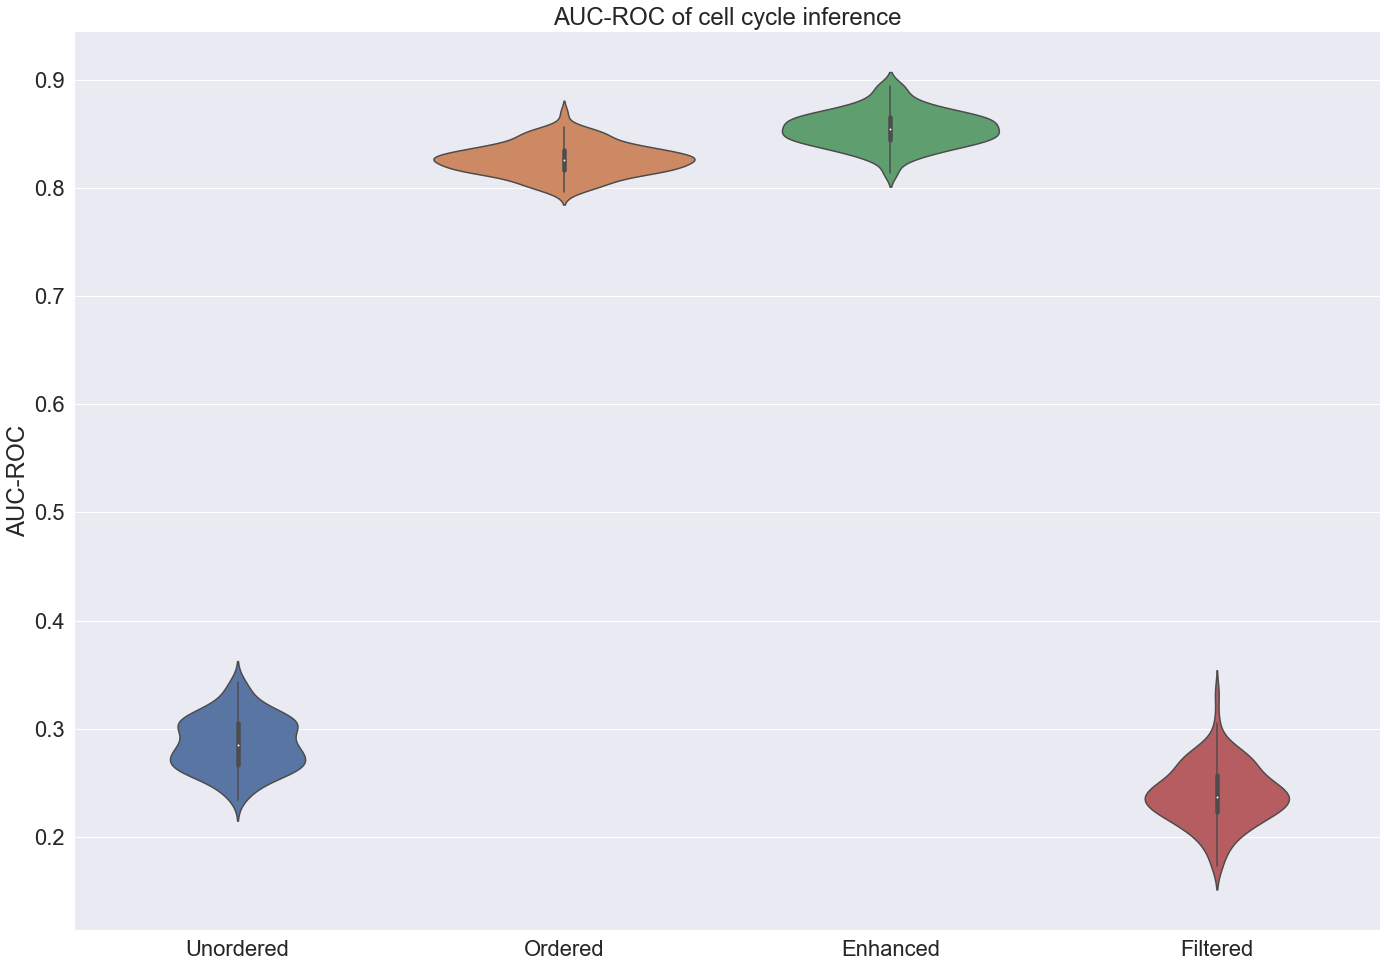

In [25]:
data = pd.DataFrame({
    "Unordered": auc_unordered,
    'Ordered': auc_ordered,
    "Enhanced": auc_en,
    "Filtered": auc_filtered,
})

sns.set_style("white", {"axes.facecolor": ".9"})
sns.set(font_scale=2)
ax = sns.violinplot(data=data)
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC of cell cycle inference" ,fontsize='24')
plt.show()